[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana2/Intro_Keras.ipynb)

# Problema

Esta semana utilizaremos el mismo DataSet para ambas sesiones. Ésta primera sesión será para analizar un problema de fraude de modo sencillo, es decir, con un clasificador binario sencillo (que nos servirá para introducir algunas herramientas).

Podemos encontrar la base de datos en https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Los datos contienen transacciones realizadas mediante trarjeta de crédito en Septiembre del 2013 por titulares de tarjeta en Europa. Ocurrieron en 2 días en los que hubo 492 fraudes de 284,807 transacciones.

Solo contiene variables numéricas y ya pasó por un proceso de PCA para solo quedarse con las mejores características.

La columna de "Time" contiene los segundos ocurridos entre transacciones. "Amount" es la cantidad de la transacción y "Class" es la variable que tiene 1 en caso de fraude y 0 en caso contrario.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Cruso-ApsFinancieras/semana3/'

# Leer Datos usando un método distinto al que estamos acostumbrados

In [ ]:
import numpy as np

# Datos disponibles en https://www.kaggle.com/mlg-ulb/creditcardfraud/

all_features = []
all_targets = []
with open('/content/drive/MyDrive/Cruso-ApsFinancieras/semana3/creditcard.csv') as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("EJEMPLO DE CARACTERÍSTICAS:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EJEMPLO DE CARACTERÍSTICAS: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
features.shape: (284807, 30)
targets.shape: (284807, 1)


# Preparar conjunto de validación

Lo haremos manual (es decir, no aleatorio)

In [ ]:
num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Número de muestras para entrenamiento:", len(train_features))
print("Número de muestras para validación:", len(val_features))

Número de muestras para entrenamiento: 227846
Número de muestras para validación: 56961


In [ ]:
num_val_samples

56961

# Analizar desbalance de los datos

In [ ]:
counts = np.bincount(train_targets[:, 0])
print(f"Número de valores 1 en muestra de entrenamiento: {counts[1]} ({100 * float(counts[1]) / len(train_targets):.2f}% of total)")

Número de valores 1 en muestra de entrenamiento: 417 (0.18% of total)


Asignaremos pesos de una manera balanceada (es una clase de peso "balanced" utilizada en keras). Manualmente se calcula como:

In [ ]:
total_counts = np.bincount(train_targets[:, 0])
n_samples = len(train_targets)

weight_for_0 = n_samples / (total_counts[0]*2)
weight_for_1 = n_samples / (total_counts[1]*2)

#counts = np.bincount(train_targets[:, 0])

#weight_for_0 = 1.0 / counts[0]
#weight_for_1 = 1.0 / counts[1]

print(f"{weight_for_0: .6f}")
print(f"{weight_for_1: .4f}")

 0.500917
 273.1966


Podemos ver que los pesos son practicamente una proporción de 500 a 1 aproximadamente

# Estandarizar los datos

In [ ]:
mean = np.mean(train_features, axis=0)
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std

# Modelo de clasificación binaria

In [ ]:
arreglo = np.array([[1,2,3], [4,5,6]])
arreglo

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
arreglo[:, 1:]

array([[2, 3],
       [5, 6]])

In [ ]:
train_features = train_features[:, 1:]
val_features = val_features[:, 1:]

In [ ]:
train_features.shape[-1]

29

In [ ]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               7680      
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 139,521
Trainable params: 139,521
Non-tr

# Entrenar modelo tomando en cuenta pesos para los datos


In [ ]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss="binary_crossentropy", metrics=metrics # El 0.01 es llamado "learning rate"
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    train_features,
    train_targets,
    batch_size=2048, # Cantidad de datos que optimizan pesos por cada pasada "batch size"
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)

Epoch 1/30
112/112 - 6s - loss: 0.3488 - fn: 51.0000 - fp: 15283.0000 - tn: 212146.0000 - tp: 366.0000 - precision: 0.0234 - recall: 0.8777 - val_loss: 0.1405 - val_fn: 7.0000 - val_fp: 2714.0000 - val_tn: 54172.0000 - val_tp: 68.0000 - val_precision: 0.0244 - val_recall: 0.9067 - 6s/epoch - 49ms/step
Epoch 2/30
112/112 - 4s - loss: 0.3199 - fn: 40.0000 - fp: 10819.0000 - tn: 216610.0000 - tp: 377.0000 - precision: 0.0337 - recall: 0.9041 - val_loss: 0.1100 - val_fn: 10.0000 - val_fp: 603.0000 - val_tn: 56283.0000 - val_tp: 65.0000 - val_precision: 0.0973 - val_recall: 0.8667 - 4s/epoch - 33ms/step
Epoch 3/30
112/112 - 4s - loss: 0.5123 - fn: 43.0000 - fp: 12582.0000 - tn: 214847.0000 - tp: 374.0000 - precision: 0.0289 - recall: 0.8969 - val_loss: 0.0602 - val_fn: 16.0000 - val_fp: 208.0000 - val_tn: 56678.0000 - val_tp: 59.0000 - val_precision: 0.2210 - val_recall: 0.7867 - 4s/epoch - 33ms/step
Epoch 4/30
112/112 - 4s - loss: 1.0634 - fn: 41.0000 - fp: 14225.0000 - tn: 213204.0000 - t

In [ ]:
y_train_pred = model.predict(train_features)
y_train_pred[y_train_pred < 0.5] = 0
y_train_pred[y_train_pred >= 0.5] = 1

In [ ]:
y_test_pred = model.predict(val_features)
y_test_pred[y_test_pred < 0.5] = 0
y_test_pred[y_test_pred >= 0.5] = 1

In [ ]:
len(y_test_pred[:, 0])

56961

In [ ]:
y_test_pred[:, 0].sum()

5333.0

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

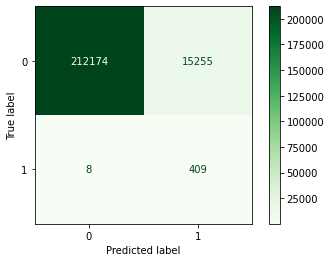

In [ ]:
ConfusionMatrixDisplay.from_predictions(train_targets, y_train_pred, cmap=plt.cm.Greens)

In [ ]:
# Recuperar "pesos" de los coeficientes en la epoca "X"
# CUIDADO AL CORRER ESTA CELDA

# model.load_weights("/content/fraud_model_at_epoch_25.h5")

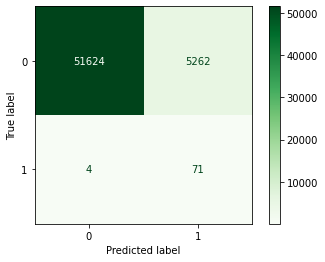

In [ ]:
ConfusionMatrixDisplay.from_predictions(val_targets, y_test_pred, cmap=plt.cm.Greens)

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:
y_test_prob = model.predict(val_features)

In [ ]:
y_test_prob

array([[0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       ...,
       [1.7846546e-20],
       [2.7972164e-24],
       [3.8993514e-01]], dtype=float32)

In [ ]:
auprc = average_precision_score(val_targets, y_test_prob)
auprc

0.6904053155336514

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(train_targets, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97    227429
           1       0.03      0.98      0.05       417

    accuracy                           0.93    227846
   macro avg       0.51      0.96      0.51    227846
weighted avg       1.00      0.93      0.96    227846



In [ ]:
print(classification_report(val_targets, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56886
           1       0.01      0.95      0.03        75

    accuracy                           0.91     56961
   macro avg       0.51      0.93      0.49     56961
weighted avg       1.00      0.91      0.95     56961



# Ejercicios:

* ¿Que sucedería con el modelo si no usamos el parámetro "class_weight"?

* ¿Podemos recuperar solo la mejor época de nuestro entrenamiento?

* ¿Porque la matriz de confusión no parece dar mucha luz sobre lo que ocurre?

 - Cargar los datos utilizando Pandas
 - Realizar la división de entrenamiento y prueba usando la función 'train_test_split' de sklearn

In [ ]:
# Código de ejercicio, puede crear mas celdas